# Business Problem Solving

- Business Understanding
- Develop Hypothesis
- Data Collection
- Problem Mapping
- Solution Approach
- EDA
- Model Building
- Model Evaluation

# 1. Business Understanding

Life Insurance Corp Ltd. is an insurance company which sells its various insurance products to the customers. Company's revenue is largely dependent on the sale of insurance products and the claims related to it - claim being insurance amount that need to be reimbursed in the event of an applicant's death. The Company is facing the problem of increasing claims and decreasing claim settlement ratio. The companies claim percentage has increased from 5% to 11% and claim settlement ratio has declined from 96% to 89% which is a concern for the insurance company. The company wants to reduce claim percentage and increase claim settlement ratio.

# 2. Developing Hypothesis

- The variables are significant in predicting risk probability of an applicant
- The data set has a pattern for segmentation on the basis of risk probability of an applicant

# 3. Data Collection

- The relevant data has been given to us which we can use to perform our analysis and if necessary model building
- `Note` that some of the variables are `already normalized` like Ins_Age, Ht, Wt etc., we need to perform normalization on non-normalized variables only and perform our analysis

# 4. Problem Mapping

- Problem Mapping would be to consider `Risky` as the `Target Variable` and consider it to be a `classification problem` i.e. given certain data we can predict probability of an applicant who is covered under insurance being risky. We will generate a score(Risk Index) on the basis of risk probability and assign it to every applicant, and then segment the applicants on the basis of `Age`, `Height`, `Weight` and `Risk Index`. We will create a 'Risk Index' column on the basis of risk probability that we will predict from our xgboost model. After assigning risk index to the applicants we will segment them using kmeans clustering.

# 5. Solution Approach

- Performing EDA on relevant variales
- We will first use XGBoost to generate the risk probability and assign it to each applicant
- We will perform KMeans clustering to segment the applicants on the basis of age, height, weight and risk probability

# 6. Exploratory Data Analysis(EDA)

## Importing relevant libraries and adjusting display settings

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, precision_score, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier

In [12]:
# To display all results of a single cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [13]:
# Setting display options

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 150)
plt.style.use('fivethirtyeight')

## Importing the data

In [14]:
# Importing the dataset

life_ins = pd.read_csv('train_LifeInsurance_RiskAssess_modified.csv')

In [15]:
# Checking head of the dataset

life_ins.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Risky
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,4.0,112,2,1,1,3,2,2,1,NaN,3,2,3,3,240.0,3,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,5.0,412,2,1,1,3,2,2,1,NaN,3,2,3,3,0.0,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,10.0,3,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,0.0,350,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,2,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


- ***Observations:***
- Please note that the data set is already normalized for the continuous variable
- Those variables are ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6',  'Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5']

In [16]:
life_ins.shape

(59381, 128)

In [17]:
# Looking at info of columns

life_ins.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Data columns (total 128 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Id                   int64  
 1   Product_Info_1       int64  
 2   Product_Info_2       object 
 3   Product_Info_3       int64  
 4   Product_Info_4       float64
 5   Product_Info_5       int64  
 6   Product_Info_6       int64  
 7   Product_Info_7       int64  
 8   Ins_Age              float64
 9   Ht                   float64
 10  Wt                   float64
 11  BMI                  float64
 12  Employment_Info_1    float64
 13  Employment_Info_2    int64  
 14  Employment_Info_3    int64  
 15  Employment_Info_4    float64
 16  Employment_Info_5    int64  
 17  Employment_Info_6    float64
 18  InsuredInfo_1        int64  
 19  InsuredInfo_2        int64  
 20  InsuredInfo_3        int64  
 21  InsuredInfo_4        int64  
 22  InsuredInfo_5        int64  
 23  InsuredInfo_6        int64  
 24  I

In [18]:
# Checking for outliers, central tendency and variance of numerical columns in the data

life_ins.describe(percentiles=[0.25, 0.50, 0.75, 0.95, 0.99])

,Id,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Risky
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59362.000000,59381.000000,59381.000000,52602.000000,59381.000000,48527.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,33985.000000,59381.000000,59381.000000,59381.000000,59381.000000,30725.000000,25140.000000,40197.000000,17570.000000,50492.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,557.000000,59381.000000,59381.000000,59381.000000,59381.000000,14785.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,3801.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,1107.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000
mean,39507.211515,1.026355,24.415655,0.328952,2.006955,2.673599,1.043583,0.405567,0.707283,0.292587,0.469462,0.077582,8.

- Q1 = 25 percentile, Q2 = 50 percentile, Q3 = 75 percentile, `IQR` = Q3 - Q2
- Commonly used metric for outlier detection is `IQR` 1.5 rule
- The `IOR` 1.5 rule is that data point less than lower limit i.e (Q1 - IQR\*1.5) and more than upper limit i.e ( Q3 + IQR\*1.5) are considered to be an outlier

- ***Observations:***
- There are outliers in 'Employment_Info_2' and Medical_History_1 variables
- The continuous variables have been normalized
- The categorical variables are dummy encoded and label encoded

In [19]:
# Checking for duplicates

life_ins.duplicated().sum()

0

- **Removing variables with more than 50% missing values**

In [20]:
# Checking for missing values

life_ins.isnull().sum()/len(life_ins.index)*100

Id                      0.000000
Product_Info_1          0.000000
Product_Info_2          0.000000
Product_Info_3          0.000000
Product_Info_4          0.000000
Product_Info_5          0.000000
Product_Info_6          0.000000
Product_Info_7          0.000000
Ins_Age                 0.000000
Ht                      0.000000
Wt                      0.000000
BMI                     0.000000
Employment_Info_1       0.031997
Employment_Info_2       0.000000
Employment_Info_3       0.000000
Employment_Info_4      11.416110
Employment_Info_5       0.000000
Employment_Info_6      18.278574
InsuredInfo_1           0.000000
InsuredInfo_2           0.000000
InsuredInfo_3           0.000000
InsuredInfo_4           0.000000
InsuredInfo_5           0.000000
InsuredInfo_6           0.000000
InsuredInfo_7           0.000000
Insurance_History_1     0.000000
Insurance_History_2     0.000000
Insurance_History_3     0.000000
Insurance_History_4     0.000000
Insurance_History_5    42.767889
Insurance_

- ***Observation:***
- We will remove the variables with more than 30% missing values as imputing them may skew the predictions and also those variables are not that important in predicting the class
- Regarding variable 'Product_Info_2', no information is given about the variable and its categories and since the variables have already been converted into dummy variables or label encoded variables apart from this variable, it is better to drop this variable due to lack of information

In [21]:
# Dropping the variables with more than 30% missing values and unnecessary variable i.e. 'Id'

life_risk = life_ins.drop(['Id','Product_Info_2', 'Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 
                           'Family_Hist_5', 'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 
                           'Medical_History_32'], axis=1)

In [22]:
# Filtering indices of variables with missing values

miss_index = list(list(np.where((round((life_risk.isnull().sum()/len(life_risk.index))*100,2))>0))[0])

In [23]:
# Filtering names of variables with missing values

miss_list = list(pd.DataFrame(life_risk.isnull().sum()/len(life_risk.index)*100).reset_index().iloc[miss_index]['index'])

In [24]:
# Checking for minimum value for variables with missing values

life_risk[miss_list].describe()

,Employment_Info_1,Employment_Info_4,Employment_Info_6,Medical_History_1
count,59362.000000,52602.000000,48527.000000,50492.000000
mean,0.077582,0.006283,0.361469,7.962172
std,0.082347,0.032816,0.349551,13.027697
min,0.000000,0.000000,0.000000,0.000000
25%,0.035000,0.000000,0.060000,2.000000
50%,0.060000,0.000000,0.250000,4.000000
75%,0.100000,0.000000,0.550000,9.000000
max,1.000000,1.000000,1.000000,240.000000


- ***Observations:***
- We will use KNN imputer to impute the missing values in these variables

- **Dropping highly skewed variables i.e. any categorical or discrete variables having more than 80% data points in particular category**

In [25]:
# Creating list of very Skewed variables which have more than 80% of a particular category

skew_vars = []

for col in life_risk.columns:
    for i in life_risk[col].value_counts():
        if (i/len(life_risk.index)*100 > 80):
            skew_vars.append(col)
skew_vars.sort()
print(skew_vars, end='')

['Employment_Info_3', 'Employment_Info_5', 'Insurance_History_2', 'InsuredInfo_2', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_7', 'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 'Medical_History_18', 'Medical_History_19', 'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_25', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_3', 'Medical_History_30', 'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 'Medical_History_40', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_Keyword_1', 'Medical_Keyword_10', 'Medical_Keyword_11', 'Medical_Keyword_12', 'Medical_Keyword_13', 'Medical_Keyword_14', 'Medical_Keyword_15', 'Medical_Keyword_16', 'Medical_Keyword_17', 'Medical_Keyword_18', 'Medical_Keywo

In [26]:
# Removing very skewed categorical variables as these do not contain much information

life_risk.drop(skew_vars, axis=1, inplace=True)

In [27]:
# Checking shape after modification

life_risk.shape

(59381, 28)

- **Imputing missing valyes using 'Iterative Imputer'**

In [28]:
# Using Iterative imputer to impute missing values

knn_impute = KNNImputer()
life_risk[miss_list] = knn_impute.fit_transform(life_risk[miss_list])
life_risk.head()

,Product_Info_4,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_4,Employment_Info_6,InsuredInfo_1,InsuredInfo_3,InsuredInfo_6,Insurance_History_1,Insurance_History_3,Insurance_History_4,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Medical_History_1,Medical_History_2,Medical_History_4,Medical_History_9,Medical_History_23,Medical_History_29,Medical_History_36,Medical_History_41,Risky
0,0.076923,0.641791,0.581818,0.148536,0.323008,0.028,12,0.0,0.0664,1,6,2,1,3,1,1,1,2,2,4.0,112,1,1,3,3,2,3,1
1,0.076923,0.059701,0.600000,0.131799,0.272288,0.000,1,0.0,0.0018,1,6,2,2,3,1,1,3,2,2,5.0,412,1,1,3,3,2,1,0
2,0.076923,0.029851,0.745455,0.288703,0.428780,0.030,9,0.0,0.0300,1,8,1,2,1,3,3,2,3,3,10.0,3,2,2,3,3,3,1,1
3,0.487179,0.164179,0.672727,0.205021,0.352438,0.042,9,0.0,0.2000,2,8,2,2,1,3,3,2,3,3,0.0,350,2,2,3,3,2,1,1
4,0.230769,0.417910,0.654545,0.234310,0.424046,0.027,9,0.0,0.0500,1,6,2,2,1,3,3,2,3,2,3.6,162,2,2,3,3,3,1,1


In [29]:
# Checking how many columns have null percentage more than 0 after modification

len(list(list(np.where((round((life_risk.isnull().sum()/len(life_risk.index))*100,2))>0))[0]))

0

- **Checking for outliers in 'Employment_Info_2' and 'Medical_History_1'**

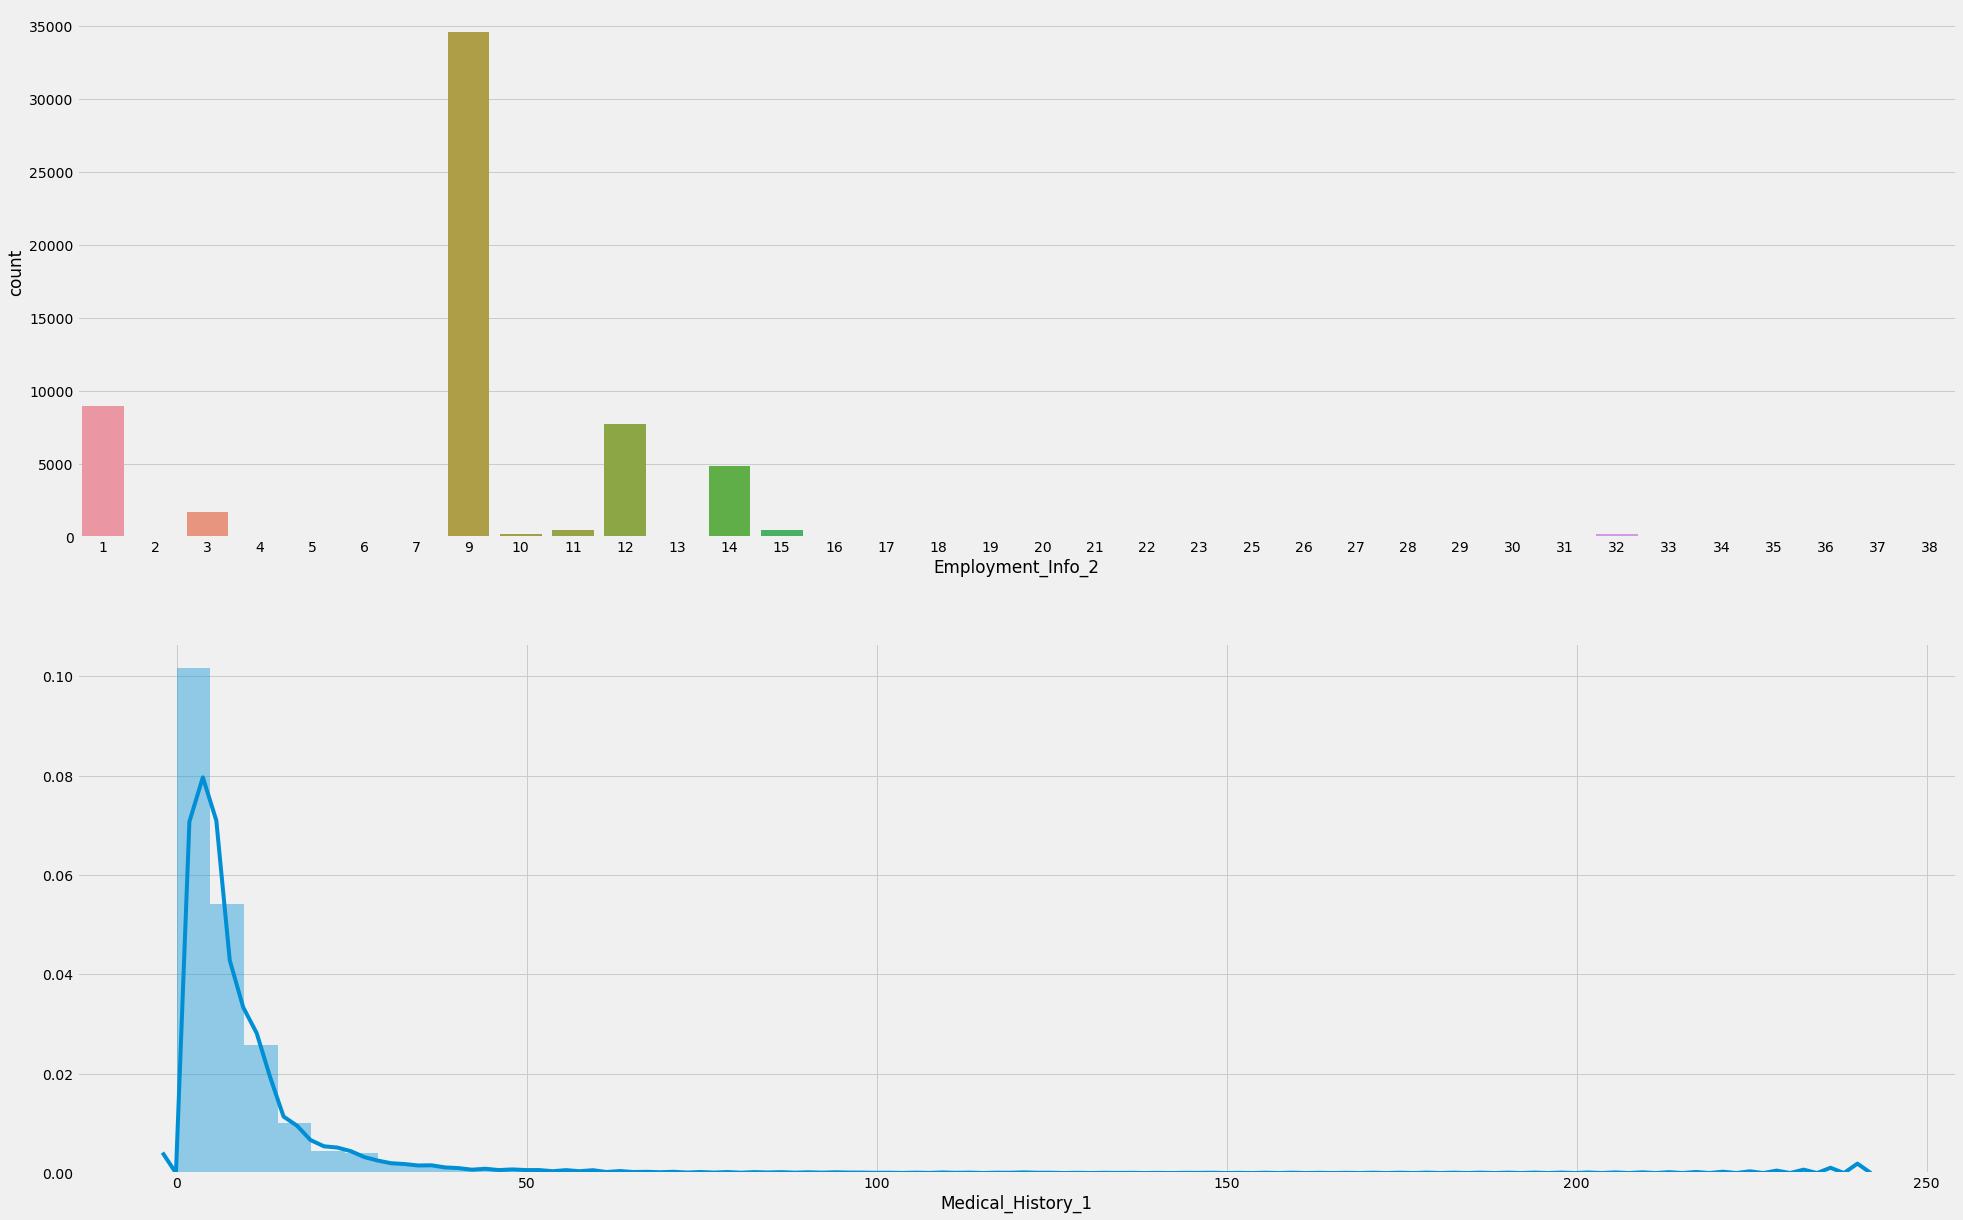

In [30]:
# Ploting count plot for 'Employment_Info_2' and 'Medical_History_1'

plt.figure(figsize=(30,20))

plt.subplot(211)
sb.countplot(life_risk['Employment_Info_2'].astype('int'))

plt.subplot(212)
sb.distplot(life_risk['Medical_History_1'])

plt.show();

- ***Observations:***
- We can see that the variables 'Employment_Info_2' and 'Medical_History_1' are very skewed
- In variable `Employment_Info_2`, category 9 has maximum number of applicants and it is around 35000 and second highest is category 1 and it is around 9000
- In variable `Medical_History_1`, there are large number of applicants who have categories below 20 and few of them are around category 240
- We can use power transform to make them more gaussian, however we will keep those variables as is for now

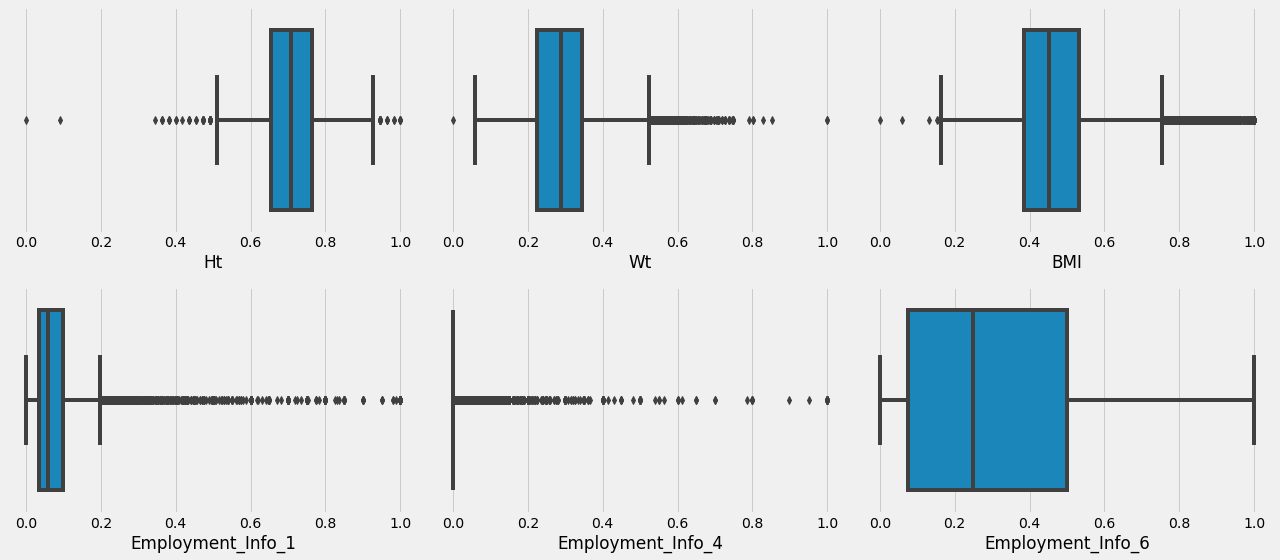

In [31]:
# Plotting boxplot for the following variables

cols = ['Ht', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6']

plt.figure(figsize=(18,8))
for col in enumerate(cols):
    plt.subplot(2,3,col[0]+1)
    sb.boxplot(life_risk[col[1]])
plt.tight_layout()
plt.show();

- ***Observations:***
- **`Ht`**
- This variable is scaled
- The height variable has outliers above and below the upper whiskers and lower whiskers respectively, it means there are customers with less height and more height
- Few of the data points below the lower whisker are far off
- The data points are divided equally above and below the median within Inter Quartile Range (IQR)
- The IQR is less which means the data points are close to each other
- **`Wt`**
- This variable is scaled
- The weight variable has lot of outliers above and below the upper whiskers and lower whiskers respectively, it means there are customers who are underweight and overweight
- It seems there are lot of people who are overweight since there are lot of data points above the upper whisker
- The data points are divided equally above and below the median within Inter Quartile Range (IQR)
- The IQR is less which means the data points are close to each other
- **`BMI`**
- This variable is scaled
- Body Mass Index (BMI) variable has outliers above and below the upper whiskers and lower whiskers respectively, more so above the upper whiskers
- Since BMI is calculated using height and weight, less height and less weight contributes to lower BMI, more height and more weight contributes to higher BMI, which explains the reason for outliers
- Within the IQR, data points below the median have less spread i.e. they close to each other, data points above the median have more spread i.e. they are a bit far away from each other
- **`Emloyment_Info_1`**
- This variable is scaled
- The Emloyment_Info_1 variable is very much right skewed, which means even in original data set i.e. unscaled data set the mean is greater than the median value
- The variable has lot of outliers above the upper whisker which is skewing the data
- From the boxplot we can infer that within the IQR, data points below the median have less spread i.e. they close to each other, data points above the median have more spread i.e. they are a bit far away from each other
- **`Emloyment_Info_4`**
- This variable is scaled
- Emloyment_Info_4 variable is very much right skewed, which means even in original data set i.e. unscaled data set the mean is greater than the median value
- The variable has lot of outliers above the upper whisker which is skewing the data very much
- This variable is so much right skewed that the IQR is not visible, hence we cannot interpret the IQR
- **`Emloyment_Info_6`**
- The Emloyment_Info_6 variable has lot of outliers avove the upper whisker
- Within the IQR, data points below the median have less spread i.e. they close to each other, data points above the median have more spread i.e. they are a bit far away from each other

- **Checking for Class imbalance**

In [32]:
# Checking for imbalance in the 'Opportunity Status' variable in percentage

round(life_risk['Risky'].value_counts(normalize=True) * 100, 2)

0    67.18
1    32.82
Name: Risky, dtype: float64

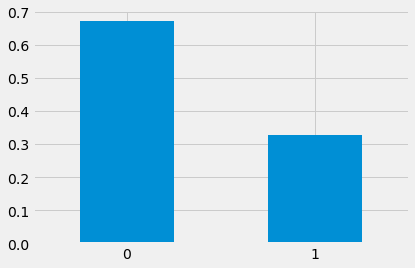

In [33]:
# Looking at the graph of the imbalance variable

life_risk['Risky'].value_counts(normalize=True).plot(kind='bar', rot=False)
plt.show();

- ***Observations:***
- We can see that there is imbalance in the dataset, we need to keep this in mind while using performance metrics like accuracy, recall etc.
- 'Risky' == 1 means that the customer is prone to high risk and this is around 33%
- 'Risky' == 0 means that the customer is not prone to high risk and this is around 67%

# 7. Model building using XGBoost

### Performing Train, Test split

In [34]:
# Bifurcating features and target variable

X = life_risk.drop('Risky', axis=1)
y = life_risk['Risky']

In [35]:
# Performing train, test split

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, stratify = y, shuffle=True, random_state=42)

In [36]:
# Checking shape of resultant data sets

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((41566, 27), (17815, 27), (41566,), (17815,))

### Feature Scaling - MinMax Scaler

- **Performing normalization on ordinal variables**

In [37]:
X_train.head()

,Product_Info_4,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_4,Employment_Info_6,InsuredInfo_1,InsuredInfo_3,InsuredInfo_6,Insurance_History_1,Insurance_History_3,Insurance_History_4,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Medical_History_1,Medical_History_2,Medical_History_4,Medical_History_9,Medical_History_23,Medical_History_29,Medical_History_36,Medical_History_41
39317,0.128205,0.074627,0.727273,0.194561,0.289568,0.045,1,0.000,0.1250,1,11,2,2,1,3,3,2,3,2,1.0,514,1,2,3,1,1,3
23480,0.487179,0.119403,0.709091,0.209205,0.328676,0.050,9,0.000,0.1150,1,3,2,2,1,3,3,2,3,2,2.0,600,2,2,3,3,2,3
13075,0.384615,0.611940,0.618182,0.244770,0.484034,0.075,1,0.000,1.0000,1,3,2,1,3,1,2,1,2,3,3.0,181,2,1,1,3,2,1
33647,0.000000,0.671642,0.690909,0.236402,0.392133,0.013,9,0.023,0.1734,1,6,1,1,3,1,1,1,2,3,1.0,610,1,1,1,3,2,3
52121,0.230769,0.328358,0.727273,0.200837,0.300036,0.020,9,0.000,0.0050,1,3,2,1,3,1,1,1,2,3,11.0,161,2,1,3,3,2,3


In [38]:
# Making kist of variables to scale

to_scale = ['Employment_Info_2', 'InsuredInfo_1', 'InsuredInfo_3', 'InsuredInfo_6', 'Insurance_History_1',
            'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_7', 'Insurance_History_8', 
           'Insurance_History_9', 'Family_Hist_1', 'Medical_History_1', 'Medical_History_2', 'Medical_History_4', 
            'Medical_History_9', 'Medical_History_23', 'Medical_History_29', 'Medical_History_36', 'Medical_History_41']

In [39]:
# Creatin copy of the variables to avoid 'setting with copy warning'

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [40]:
# Initiating MinMax scaler, fitting and transforming the train data set

mms = MinMaxScaler()
X_train_scaled[to_scale] = mms.fit_transform(X_train_scaled[to_scale])

In [41]:
# Performing MinMax transform on the test data set

X_test_scaled[to_scale] = mms.transform(X_test_scaled[to_scale])

In [42]:
X_train_scaled.head()

,Product_Info_4,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_4,Employment_Info_6,InsuredInfo_1,InsuredInfo_3,InsuredInfo_6,Insurance_History_1,Insurance_History_3,Insurance_History_4,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Medical_History_1,Medical_History_2,Medical_History_4,Medical_History_9,Medical_History_23,Medical_History_29,Medical_History_36,Medical_History_41
39317,0.128205,0.074627,0.727273,0.194561,0.289568,0.045,0.000000,0.000,0.1250,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.5,1.0,0.5,0.004167,0.792890,0.0,0.5,1.0,0.0,0.0,1.0
23480,0.487179,0.119403,0.709091,0.209205,0.328676,0.050,0.216216,0.000,0.1150,0.0,0.2,1.0,1.0,0.0,1.0,1.0,0.5,1.0,0.5,0.008333,0.925811,1.0,0.5,1.0,1.0,0.5,1.0
13075,0.384615,0.611940,0.618182,0.244770,0.484034,0.075,0.000000,0.000,1.0000,0.0,0.2,1.0,0.0,1.0,0.0,0.5,0.0,0.5,1.0,0.012500,0.278207,1.0,0.0,0.0,1.0,0.5,0.0
33647,0.000000,0.671642,0.690909,0.236402,0.392133,0.013,0.216216,0.023,0.1734,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.5,1.0,0.004167,0.941267,0.0,0.0,0.0,1.0,0.5,1.0
52121,0.230769,0.328358,0.727273,0.200837,0.300036,0.020,0.216216,0.000,0.0050,0.0,0.2,1.0,0.0,1.0,0.0,0.0,0.0,0.5,1.0,0.045833,0.247295,1.0,0.0,1.0,1.0,0.5,1.0


### Using `RFE` for feature selection

In [43]:
# Using 'XGBClassifier' and 'RFE' for feature selection - Selecting 15 features

xgboost = XGBClassifier()
rfe = RFE(xgboost,n_features_to_select=15)
rfe = rfe.fit(X_train_scaled,y_train)

In [44]:
# Keeping only those columns which were selected using RFE

col = X_train_scaled.columns[rfe.support_]
X_train_scaled = X_train_scaled[col]
X_test_scaled = X_test_scaled[col]
X_train_scaled.head()

,Product_Info_4,Ins_Age,Wt,BMI,Employment_Info_2,Employment_Info_6,InsuredInfo_3,InsuredInfo_6,Insurance_History_7,Insurance_History_9,Family_Hist_1,Medical_History_1,Medical_History_2,Medical_History_4,Medical_History_23
39317,0.128205,0.074627,0.194561,0.289568,0.000000,0.1250,1.0,1.0,1.0,1.0,0.5,0.004167,0.792890,0.0,1.0
23480,0.487179,0.119403,0.209205,0.328676,0.216216,0.1150,0.2,1.0,1.0,1.0,0.5,0.008333,0.925811,1.0,1.0
13075,0.384615,0.611940,0.244770,0.484034,0.000000,1.0000,0.2,1.0,0.5,0.5,1.0,0.012500,0.278207,1.0,0.0
33647,0.000000,0.671642,0.236402,0.392133,0.216216,0.1734,0.5,0.0,0.0,0.5,1.0,0.004167,0.941267,0.0,0.0
52121,0.230769,0.328358,0.200837,0.300036,0.216216,0.0050,0.2,1.0,0.0,0.5,1.0,0.045833,0.247295,1.0,1.0


### Model Building using cross validate

In [45]:
%%time
# Using cross val score to get mean accuracy for training

rkf = RepeatedStratifiedKFold(random_state=42, n_repeats=5)
score = cross_validate(estimator=XGBClassifier(),
                       X=X_train_scaled, y=y_train, 
                       scoring=['accuracy', 'recall', 'precision'], 
                       return_train_score=True,return_estimator=True,
                       cv=rkf, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 44.1 s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   44.0s finished


# 8. Model Evaluation

In [46]:
# Converting score which is a dictionary into a data frame

cross_val_df = pd.DataFrame(score).reset_index()
cross_val_df.rename(mapper={'index':'cv'},axis=1, inplace=True)

In [47]:
# Checking the data head of resultant data frame

cross_val_df.head()

,cv,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision
0,0,1.353132,0.030912,XGBClassifier(),0.806110,0.813184,0.733236,0.737286,0.693588,0.706347
1,1,1.371071,0.029603,XGBClassifier(),0.813184,0.812919,0.730671,0.735545,0.709104,0.706478
2,2,1.688128,0.061696,XGBClassifier(),0.812944,0.812408,0.726906,0.736119,0.709989,0.705232
3,3,1.617874,0.029472,XGBClassifier(),0.810417,0.812588,0.737170,0.738318,0.700697,0.704740
4,4,1.400520,0.028550,XGBClassifier(),0.807169,0.812829,0.739370,0.740700,0.693365,0.704304


- **Analysing different metrics**

In [48]:
# Sorting Cross validation models in the decreasing order of the recall score

cross_val_df.sort_values(by='test_recall', ascending=False).head()

,cv,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision
14,14,1.352103,0.030450,XGBClassifier(),0.815951,0.810784,0.745601,0.732729,0.708711,0.703218
11,11,1.584119,0.065386,XGBClassifier(),0.812342,0.813100,0.740931,0.736278,0.703304,0.706560
9,9,2.123805,0.028928,XGBClassifier(),0.812703,0.811716,0.740469,0.736485,0.704078,0.703668
20,20,1.343431,0.025443,XGBClassifier(),0.813207,0.812252,0.739831,0.732612,0.705451,0.706272
4,4,1.400520,0.028550,XGBClassifier(),0.807169,0.812829,0.739370,0.740700,0.693365,0.704304
15,15,1.383716,0.027892,XGBClassifier(),0.809839,0.813064,0.737999,0.736003,0.699306,0.706607
3,3,1.617874,0.029472,XGBClassifier(),0.810417,0.812588,0.737170,0.738318,0.700697,0.704740
7,7,1.392956,0.035022,XGBClassifier(),0.805245,0.813130,0.736070,0.739601,0.690746,0.705348
23,23,1.331902,0.025099,XGBClassifier(),0.805726,0.813069,0.735337,0.736668,0.691963,0.706378
5,5,1.358464,0.025425,XGBClassifier(),0.809237,0.813214,0.735068,0.736278,0.699198,0.706809


In [49]:
# Cross validation model number 14 is the optimal model

cv_opt_est = score['estimator'][14]

- ***Observations:***
- We will use the model which has best test_recall score and use it for predicting the test data set and that will be our base model
- That model is cross-validation number 14

In [50]:
# Checking 'Accuracy' on the train data

accuracy_score(y_train, cv_opt_est.predict(X_train_scaled))

0.8118173507193379

In [51]:
# Checking 'Recall' on the train data

recall_score(y_train, cv_opt_est.predict(X_train_scaled))

0.7353027415334995

In [52]:
# Checking 'Precision' on the train data

precision_score(y_train, cv_opt_est.predict(X_train_scaled))

0.7043252352197725

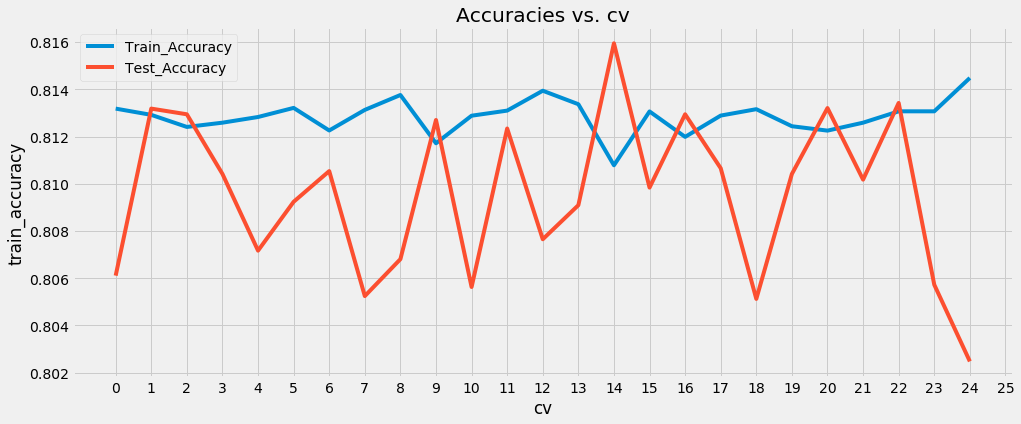

In [53]:
# Plotting train, test accuracies

plt.figure(figsize=(15,6))
sb.lineplot(data=cross_val_df, x='cv', y='train_accuracy', label='Train_Accuracy')
plt.plot(cross_val_df['test_accuracy'], label='Test_Accuracy')
plt.xticks(ticks=range(26))
plt.xlabel('Number of Cross-Validations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Cross-Validations')
plt.legend()
plt.show();

- ***Observations:***
- The plot is wavy and fluctuating for both train and test accuracy, more so for test accuracy
- From the plot we can see that the test accuracy is highest for cross-validation number 14, it is our optimal cross validation model

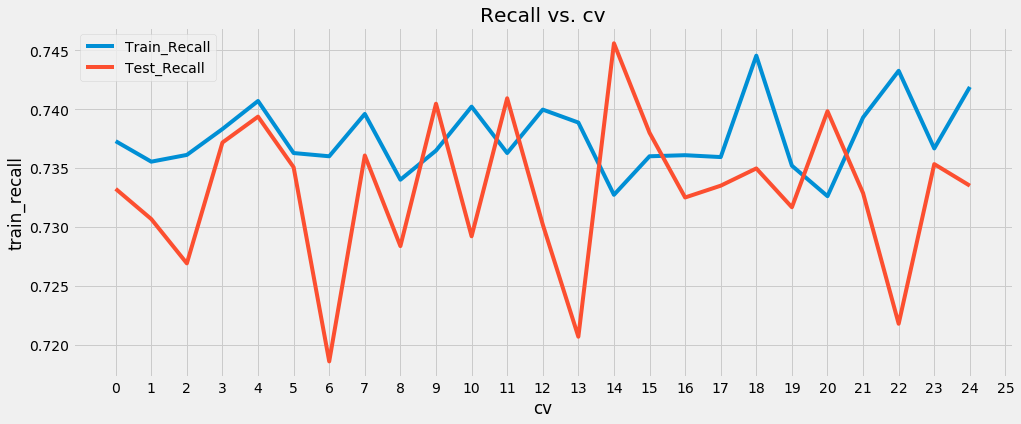

In [54]:
# Plotting train, test recall

plt.figure(figsize=(15,6))
sb.lineplot(data=cross_val_df, x='cv', y='train_recall', label='Train_Recall')
plt.plot(cross_val_df['test_recall'], label='Test_Recall')
plt.xticks(ticks=range(26))
plt.xlabel('Number of Cross-Validations')
plt.ylabel('Recall')
plt.title('Recall vs. Cross-Validations')
plt.legend()
plt.show();

- ***Observations:***
- The plot is wavy and fluctuating for both train and test recall, more so for test recall
- From the plot we can see that the test recall is highest for cross-validation number 14, it is our optimal cross validation model

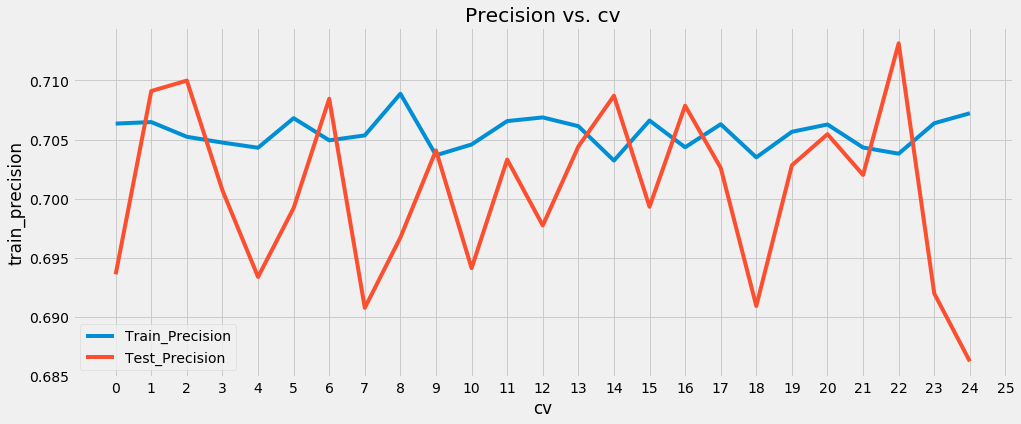

In [55]:
# Plotting train, test precision

plt.figure(figsize=(15,6))
sb.lineplot(data=cross_val_df, x='cv', y='train_precision', label='Train_Precision')
plt.plot(cross_val_df['test_precision'], label='Test_Precision')
plt.xticks(ticks=range(26))
plt.xlabel('Number of Cross-Validations')
plt.ylabel('Precision')
plt.title('Precision vs. Cross-Validations')
plt.legend()
plt.show();

- ***Observations:***
- The plot is wavy and fluctuating for both train and test precision, more so for test precision
- From the plot we can see that the test precision is highest for cross-validation number 22 model. However optimal model is cross-validation number 14
- Since we want to predict risk probability of applicants we will be using model which has high recall and a good precision which is cross-validation modal number 14

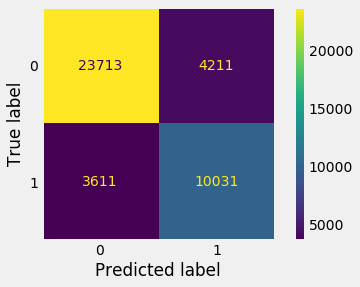

In [56]:
# Plotting confusion matrix

plot_confusion_matrix(estimator=cv_opt_est, X=X_train_scaled, y_true=y_train, values_format='d')
plt.grid([])
plt.show();

- ***Observation:***
- True Negatives(TN) - Actually they are Not Risky and model predicted them to be Not Risky
- True Positives(TP) - Actually they are Risky and model predicted them to be Risky
- False Positives(FP) - Actually they are Not Risky but model predicted them to be Risky
- False Negatives(FN) - Actually they are Risky but model predicted them to be Not Risky
- True Negatives = 23713, True Positives = 10031, False Positives = 4211, False Negatives = 3611

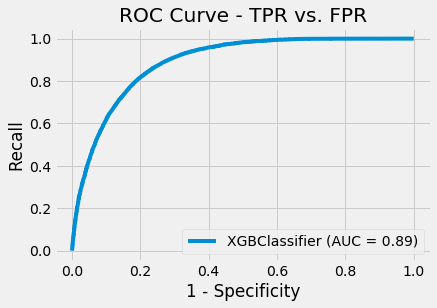

In [57]:
# Plot ROC curve along with AUC score

plot_roc_curve(estimator=cv_opt_est, X=X_train_scaled, y=y_train)
plt.ylabel('Recall')
plt.xlabel('1 - Specificity')
plt.title('ROC Curve - TPR vs. FPR')
plt.show();

- ***Observations:***
- The area under the curve is 89%, which is an improvement over cross validated Xgboost model
- we are getting  `Accuracy = 0.81`, `Sensitivity = 0.74` and `Precision = 0.70` with grid search Xgboost model, which is an improvement
- It looks using grid search did improved the performance of the Xgboost model, let us see how it predicts the test data set

- **Analysing Important Features**

In [58]:
# Creating features importance data frame for cv_opt_est model

cv_imp_feat = pd.DataFrame(cv_opt_est.feature_importances_,X_train_scaled.columns).reset_index().sort_values(by=0, ascending=False)
cv_imp_feat.columns = ['Features', 'Importance']
cv_imp_feat

,Features,Importance
3,BMI,0.282402
14,Medical_History_23,0.251228
13,Medical_History_4,0.186113
7,InsuredInfo_6,0.072541
0,Product_Info_4,0.058610
1,Ins_Age,0.026498
2,Wt,0.025815
10,Family_Hist_1,0.025803
11,Medical_History_1,0.014712
9,Insurance_History_9,0.014465


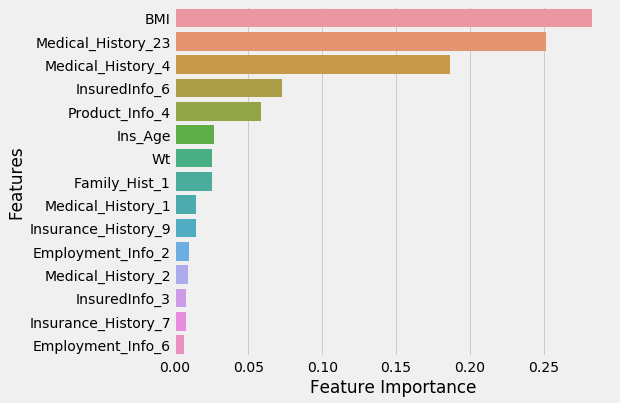

In [59]:
# Plotting feature importance for cv_opt_est model

plt.figure(figsize=(7,6))
sb.barplot(cv_imp_feat.Importance, cv_imp_feat.Features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show();

- ***Observations:***
- The GridSearchCV model chose 'BMI' to be most important feature and 'Employment_Info_6' to be least important
- The top 5 features are `BMI = 0.282`, `Medical_History_23 = 0.251`, `Medical_History_4 = 0.186`, `InsuredInfo_6 = 0.072` and `Product_Info_4 = 0.058`

### Predicting the Test data set using Cross Validation model `cv_opt_est`

- **Analysing different metrics**

In [60]:
# Checking 'Accuracy' on the test data

accuracy_score(y_test, cv_opt_est.predict(X_test_scaled))

0.8074094863878754

In [61]:
# Checking 'Recall' on the test data

recall_score(y_test, cv_opt_est.predict(X_test_scaled))

0.7260133401744484

In [62]:
# Checking 'Precision' on the test data

precision_score(y_test, cv_opt_est.predict(X_test_scaled))

0.6988804741521238

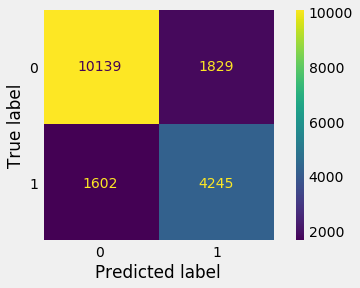

In [63]:
# Plotting confusion matrix

plot_confusion_matrix(estimator=cv_opt_est, X=X_test_scaled, y_true=y_test, values_format='d')
plt.grid([])
plt.show();

- ***Observations:***
- True Negatives = 10139, True Positives = 4245, False Positives = 1829, False Negatives = 1602

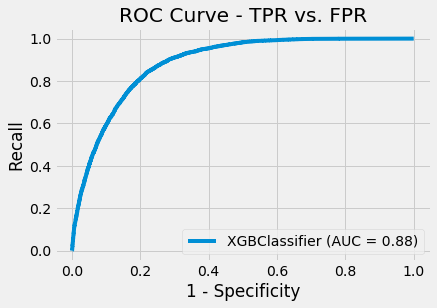

In [64]:
# Plot ROC curve along with AUC score

plot_roc_curve(estimator=cv_opt_est, X=X_test_scaled, y=y_test)
plt.ylabel('Recall')
plt.xlabel('1 - Specificity')
plt.title('ROC Curve - TPR vs. FPR')
plt.show();

- ***Observations:***
- The area under the curve is 88%, which is good
- However we are getting `Accuracy = 0.80`, `Sensitivity = 0.73` and `Precision = 0.70` with cross validated Xgboost model
- We will check if we can improve on the results given by cross validated Xgboost model by using GridSearchCV

### Grid Search for finding optimum Hyperparameters

In [65]:
%%time
# Performing Grid Search on the train data set using XGBoost as the estimator

xgb_model = XGBClassifier()

param = {'learning_rate': [0.001,0.01,0.1,0.2,0.3,0.9],
        'max_depth':[5,10,15,20,25],
        'min_child_weight':[20,25,30,35],
        'n_estimators':[50,100,200,300,500]}


clf_xgb = GridSearchCV(estimator=xgb_model,
                      param_grid=param,
                      n_jobs=-1,
                      cv=3,
                      scoring='accuracy',
                      refit=True, 
                      return_train_score=True,
                      verbose=1)

clf_xgb.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 100.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 156.0min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 158.3min finished


Wall time: 2h 38min 21s


GridSearchCV(cv=3, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.9],
                         'max_depth': [5, 10, 15, 20, 25],
                         'min_child_weight': [20, 25, 30, 35],
                         'n_estimators': [50, 100, 200, 300, 500]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [66]:
# Checking the best parameters chosen by grid search model

clf_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 25,
 'n_estimators': 100}

In [67]:
# Converting results for grid search which is a dictionary into a data frame

gs_cv_results = pd.DataFrame(clf_xgb.cv_results_)
gs_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,2.572502,0.011553,0.029751,0.000413,0.001,5,20,50,"{'learning_rate': 0.001, 'max_depth': 5, 'min_...",0.80319,0.801804,0.807795,0.804263,0.002561,281,0.804583,0.805745,0.802966,0.804432,0.001139
1,5.191618,0.090132,0.056355,0.004404,0.001,5,20,100,"{'learning_rate': 0.001, 'max_depth': 5, 'min_...",0.80319,0.801804,0.807795,0.804263,0.002561,281,0.804583,0.805781,0.802966,0.804444,0.001153
2,10.098250,0.089127,0.196172,0.052658,0.001,5,20,200,"{'learning_rate': 0.001, 'max_depth': 5, 'min_...",0.80319,0.801732,0.807795,0.804239,0.002584,293,0.804583,0.805925,0.802966,0.804492,0.001210
3,15.371540,0.558835,0.189805,0.001979,0.001,5,20,300,"{'learning_rate': 0.001, 'max_depth': 5, 'min_...",0.80319,0.801804,0.807795,0.804263,0.002561,281,0.804583,0.806034,0.802966,0.804528,0.001253
4,25.424424,0.221302,0.390960,0.062592,0.001,5,20,500,"{'learning_rate': 0.001, 'max_depth': 5, 'min_...",0.80319,0.801804,0.807506,0.804167,0.002428,303,0.804583,0.805998,0.802786,0.804456,0.001314


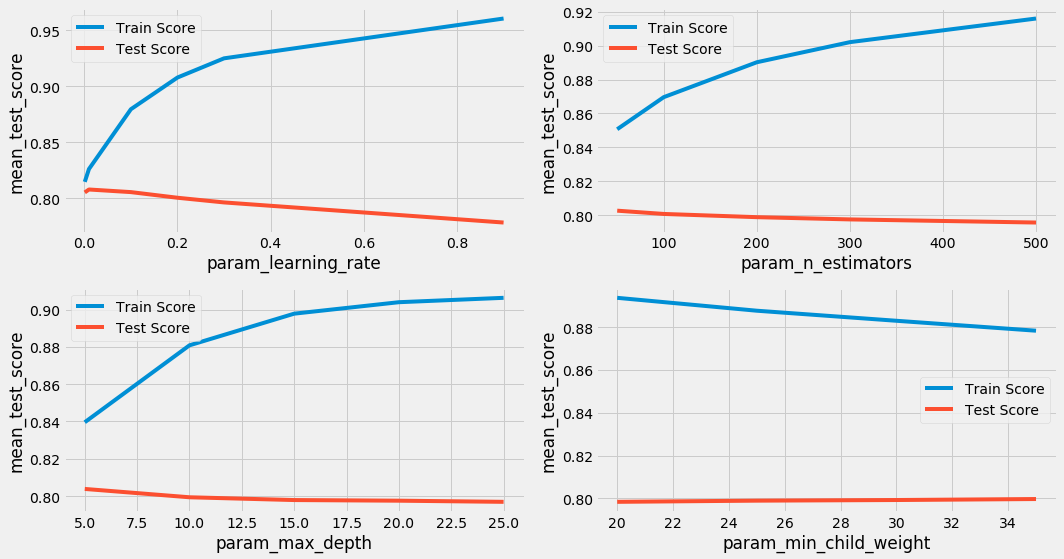

In [68]:
# Plotting mean_test_score against the hyper-parameters

plt.figure(figsize=(15,8))

plt.subplot(221)
sb.lineplot(x=gs_cv_results['param_learning_rate'], y=gs_cv_results['mean_train_score'], label='Train Score', ci=None)
sb.lineplot(x=gs_cv_results['param_learning_rate'], y=gs_cv_results['mean_test_score'], label='Test Score', ci=None)

plt.subplot(222)
sb.lineplot(x=gs_cv_results['param_n_estimators'], y=gs_cv_results['mean_train_score'], label='Train Score', ci=None)
sb.lineplot(x=gs_cv_results['param_n_estimators'], y=gs_cv_results['mean_test_score'], label='Test Score', ci=None)

plt.subplot(223)
sb.lineplot(x=gs_cv_results['param_max_depth'], y=gs_cv_results['mean_train_score'], label='Train Score', ci=None)
sb.lineplot(x=gs_cv_results['param_max_depth'], y=gs_cv_results['mean_test_score'], label='Test Score', ci=None)

plt.subplot(224)
sb.lineplot(x=gs_cv_results['param_min_child_weight'], y=gs_cv_results['mean_train_score'], label='Train Score', ci=None)
sb.lineplot(x=gs_cv_results['param_min_child_weight'], y=gs_cv_results['mean_test_score'], label='Test Score', ci=None)


plt.legend() #loc='lower right'
plt.tight_layout()
plt.show();

- ***Observations:***
- ***Note: Due to memory issues performed grid search on less parameters***
- **Top left plot**
- We can see that as learning rate increases the mean train score increases, however, the mean test score decreases, this clear case of overfitting
- We can see that low learning rate gives good mean test score
- **Top right plot**
- We can see that as n_estimators increases the mean train score increases, however, the mean test score decreases, again clear case of overfitting
- We can see that low number of estimators gives good mean test score
- **Bottom left plot**
- We can see that as max_depth increases the mean train score increases, however, the mean test score decreases initially and then becomes flat, again clear case of overfitting
- We can see that low number of max_depth gives good mean test score
- **Bottom right plot**
- We can see that as min_child_weight increases the mean train score decreases, however, the mean test score is flat through out
- We can see not much of a difference when using min_child_weight as a parameter

### Building the model again using best parameters from Xgboost

In [69]:
# Building the model again with best parameters from grid search

opt_model = XGBClassifier(learning_rate=0.1,
                            max_depth=5,
                            min_child_weight=25,
                            n_estimators=100)

opt_model.fit(X_train_scaled, y_train)

XGBClassifier(max_depth=5, min_child_weight=25)

- **Analysing different metrics**

In [70]:
# Checking 'Accuracy' on the train data

accuracy_score(y_train, opt_model.predict(X_train_scaled))

0.8196121830342107

In [71]:
# Checking 'Recall' on the train data

recall_score(y_train, opt_model.predict(X_train_scaled))

0.7426330450080634

In [72]:
# Checking 'Precision' on the train data

precision_score(y_train, opt_model.predict(X_train_scaled))

0.7175945601359967

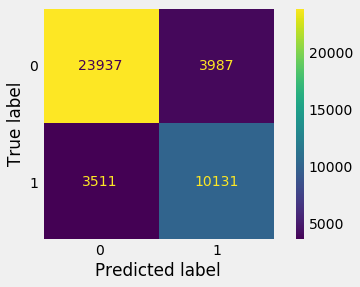

In [74]:
# Plotting confusion matrix

plot_confusion_matrix(estimator=opt_model, X=X_train_scaled, y_true=y_train, values_format='d')
plt.grid([])
plt.show();

- ***Observations:***
- True Negatives = 23937, True Positives = 10131, False Positives = 3987, False Negatives = 3511
- The results are better when we use model with grid search parameters as compared to cross-validation model on train data set

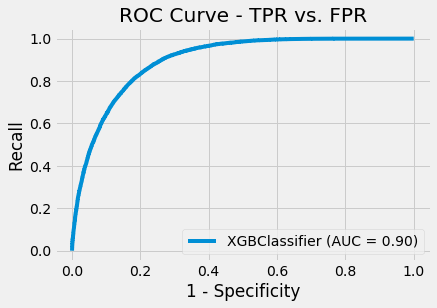

In [75]:
# Plot ROC curve along with AUC score

plot_roc_curve(estimator=opt_model, X=X_train_scaled, y=y_train)
plt.ylabel('Recall')
plt.xlabel('1 - Specificity')
plt.title('ROC Curve - TPR vs. FPR')
plt.show();

- ***Observations:***
- The area under the curve is 90%, which is an improvement over cross validated Xgboost model
- we are getting  `Accuracy = 0.81`, `Sensitivity = 0.74` and `Precision = 0.72` with grid search Xgboost model, which is an improvement
- It looks using grid search did improved the performance of the Xgboost model, let us see how it predicts the test data set

- **Analysing Important Features**

In [76]:
# Creating features importance data frame for opt_model model

gs_imp_feat = pd.DataFrame(opt_model.feature_importances_,X_train_scaled.columns).reset_index().sort_values(by=0, ascending=False)
gs_imp_feat.columns = ['Features', 'Importance']
gs_imp_feat

,Features,Importance
14,Medical_History_23,0.271960
13,Medical_History_4,0.254768
3,BMI,0.214370
7,InsuredInfo_6,0.061695
0,Product_Info_4,0.053473
10,Family_Hist_1,0.036514
1,Ins_Age,0.019708
9,Insurance_History_9,0.015346
2,Wt,0.014146
4,Employment_Info_2,0.013036


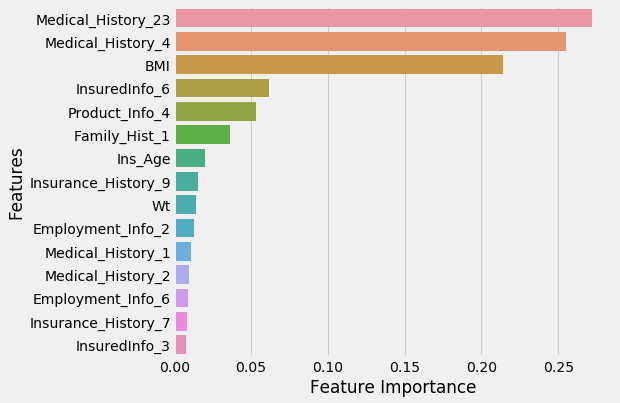

In [77]:
# Plotting feature importance for cv_opt_est model

plt.figure(figsize=(7,6))
sb.barplot(gs_imp_feat.Importance, gs_imp_feat.Features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show();

- ***Observations:***
- The GridSearchCV model chose 'Medical_History_23' to be most important feature and 'InsuredInfo_3' to be least important
- The top 5 features are `Medical_History_23 = 0.271`, `Medical_History_4 = 0.254`, `BMI = 0.214`, `InsuredInfo_6 = 0.061` and `Product_Info_4 = 0.053`

### Predicting the Test data set using GridSearch model `opt_model`

- **Analysing different metrics**

In [78]:
# Checking 'Accuracy' on the test data

accuracy_score(y_test, opt_model.predict(X_test_scaled))

0.8088689306763963

In [79]:
# Checking 'Recall' on the test data

recall_score(y_test, opt_model.predict(X_test_scaled))

0.7217376432358474

In [80]:
# Checking 'Precision' on the test data

precision_score(y_test, opt_model.predict(X_test_scaled))

0.703567855951984

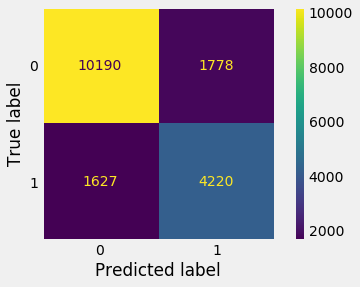

In [81]:
# Plotting confusion matrix

plot_confusion_matrix(estimator=opt_model, X=X_test_scaled, y_true=y_test, values_format='d')
plt.grid([])
plt.show();

- ***Observations:***
- True Negatives = 10190, True Positives = 4220, False Positives = 1778, False Negatives = 1627
- Grid search model predicts True Negatives better than cross-validation model, however, Grid search model predicts True Positives a bit less, i.e. 25 data points less than cross-validation model
- We will be using grid search model as precision is also important and precision for grid search model is a slightly better than cross-validation model, recall is more or less similar for both model

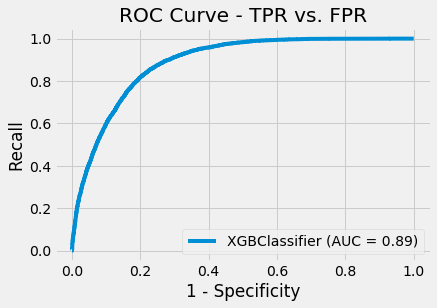

In [82]:
# Plot ROC curve along with AUC score

plot_roc_curve(estimator=opt_model, X=X_test_scaled, y=y_test)
plt.ylabel('Recall')
plt.xlabel('1 - Specificity')
plt.title('ROC Curve - TPR vs. FPR')
plt.show();

- ***Observations:***
- The area under the curve is 89%, which is good
- However we are getting `Accuracy = 0.81`, `Sensitivity = 0.72` and `Precision = 0.70` with grid search Xgboost model
- Cross validation model and GridSearchCV model perform similarly on the test data set, here we will use grid search model for risk index prediction

# 9. Generating Risk Index for complete data set 

- **Generating Risk Index for train data set**

In [83]:
# Predicting probability of X_train_scaled

y_train_pred = opt_model.predict_proba(X_train_scaled)
y_train_pred[:10]

array([[0.7165694 , 0.2834306 ],
       [0.18266803, 0.81733197],
       [0.9134806 , 0.08651941],
       [0.9896835 , 0.01031651],
       [0.17729056, 0.82270944],
       [0.98848826, 0.01151176],
       [0.23830819, 0.7616918 ],
       [0.45743245, 0.54256755],
       [0.43880838, 0.5611916 ],
       [0.8820278 , 0.11797218]], dtype=float32)

In [84]:
# Converting 'y_train_pred' into a data frame

y_train_pred = pd.DataFrame(y_train_pred, columns=['Class_0', 'Class_1'])
y_train_pred.head()

,Class_0,Class_1
0,0.716569,0.283431
1,0.182668,0.817332
2,0.913481,0.086519
3,0.989684,0.010317
4,0.177291,0.822709


In [85]:
# Resetting index as we need those indices when combining 'X_train_scaled' and 'y_train_pred'

X_train_scaled.reset_index(inplace=True)

In [86]:
# Creating a 'Risk_Index' column in 'X_train_scaled'

X_train_scaled['Risk_Index'] = y_train_pred['Class_1']*100
X_train_scaled['Risk_Index'] = round(X_train_scaled['Risk_Index'])
X_train_scaled.head()

,index,Product_Info_4,Ins_Age,Wt,BMI,Employment_Info_2,Employment_Info_6,InsuredInfo_3,InsuredInfo_6,Insurance_History_7,Insurance_History_9,Family_Hist_1,Medical_History_1,Medical_History_2,Medical_History_4,Medical_History_23,Risk_Index
0,39317,0.128205,0.074627,0.194561,0.289568,0.000000,0.1250,1.0,1.0,1.0,1.0,0.5,0.004167,0.792890,0.0,1.0,28.0
1,23480,0.487179,0.119403,0.209205,0.328676,0.216216,0.1150,0.2,1.0,1.0,1.0,0.5,0.008333,0.925811,1.0,1.0,82.0
2,13075,0.384615,0.611940,0.244770,0.484034,0.000000,1.0000,0.2,1.0,0.5,0.5,1.0,0.012500,0.278207,1.0,0.0,9.0
3,33647,0.000000,0.671642,0.236402,0.392133,0.216216,0.1734,0.5,0.0,0.0,0.5,1.0,0.004167,0.941267,0.0,0.0,1.0
4,52121,0.230769,0.328358,0.200837,0.300036,0.216216,0.0050,0.2,1.0,0.0,0.5,1.0,0.045833,0.247295,1.0,1.0,82.0


- **Generating Risk Index for test data set**

In [87]:
# Predicting probability of X_test_scaled

y_test_pred = opt_model.predict_proba(X_test_scaled)
y_test_pred[:10]

array([[0.997386  , 0.00261402],
       [0.80838686, 0.19161312],
       [0.31855237, 0.6814476 ],
       [0.82053363, 0.1794664 ],
       [0.14389765, 0.85610235],
       [0.4912154 , 0.5087846 ],
       [0.9908321 , 0.00916794],
       [0.959883  , 0.04011706],
       [0.5421946 , 0.4578054 ],
       [0.45668465, 0.54331535]], dtype=float32)

In [88]:
# Converting 'y_test_pred' into a data frame

y_test_pred = pd.DataFrame(y_test_pred, columns=['Class_0', 'Class_1'])
y_test_pred.head()

,Class_0,Class_1
0,0.997386,0.002614
1,0.808387,0.191613
2,0.318552,0.681448
3,0.820534,0.179466
4,0.143898,0.856102


In [89]:
# Resetting index as we need those indices when combining 'X_test_scaled' and 'y_test_pred'

X_test_scaled.reset_index(inplace=True)

In [90]:
# Creating a 'Risk_Index' column in 'X_test_scaled'

X_test_scaled['Risk_Index'] = y_test_pred['Class_1']*100
X_test_scaled['Risk_Index'] = round(X_test_scaled['Risk_Index'])
X_test_scaled.head()

,index,Product_Info_4,Ins_Age,Wt,BMI,Employment_Info_2,Employment_Info_6,InsuredInfo_3,InsuredInfo_6,Insurance_History_7,Insurance_History_9,Family_Hist_1,Medical_History_1,Medical_History_2,Medical_History_4,Medical_History_23,Risk_Index
0,685,0.230769,0.432836,0.351464,0.619419,0.297297,0.20,0.2,1.0,1.0,1.0,0.5,0.000000,0.171561,1.0,0.0,0.0
1,39938,0.179487,0.761194,0.299163,0.411370,0.000000,0.05,0.1,0.0,1.0,1.0,0.5,0.010000,0.248841,0.0,1.0,19.0
2,10736,0.487179,0.208955,0.297071,0.408165,0.216216,0.00,0.2,0.0,0.0,0.5,0.5,0.020000,0.248841,1.0,1.0,68.0
3,26613,0.076923,0.567164,0.361925,0.507515,0.216216,1.00,0.0,0.0,0.0,0.5,0.5,0.012500,0.766615,0.0,1.0,18.0
4,7751,0.384615,0.208955,0.163180,0.276157,0.216216,0.10,0.2,1.0,1.0,1.0,1.0,0.020833,0.539413,1.0,1.0,86.0


- **Combining train and test data sets**

In [91]:
# Combining X_train_scaled and X_test_scaled to form a new data set 'X_comb'

X_comb = pd.concat([X_train_scaled,X_test_scaled])

In [92]:
# Checking the head of the new data frame

X_comb.head()

,index,Product_Info_4,Ins_Age,Wt,BMI,Employment_Info_2,Employment_Info_6,InsuredInfo_3,InsuredInfo_6,Insurance_History_7,Insurance_History_9,Family_Hist_1,Medical_History_1,Medical_History_2,Medical_History_4,Medical_History_23,Risk_Index
0,39317,0.128205,0.074627,0.194561,0.289568,0.000000,0.1250,1.0,1.0,1.0,1.0,0.5,0.004167,0.792890,0.0,1.0,28.0
1,23480,0.487179,0.119403,0.209205,0.328676,0.216216,0.1150,0.2,1.0,1.0,1.0,0.5,0.008333,0.925811,1.0,1.0,82.0
2,13075,0.384615,0.611940,0.244770,0.484034,0.000000,1.0000,0.2,1.0,0.5,0.5,1.0,0.012500,0.278207,1.0,0.0,9.0
3,33647,0.000000,0.671642,0.236402,0.392133,0.216216,0.1734,0.5,0.0,0.0,0.5,1.0,0.004167,0.941267,0.0,0.0,1.0
4,52121,0.230769,0.328358,0.200837,0.300036,0.216216,0.0050,0.2,1.0,0.0,0.5,1.0,0.045833,0.247295,1.0,1.0,82.0


In [93]:
# Checking shape of new data frame

X_comb.shape

(59381, 17)

# 10. Building KMeans clustering

- **Adding 'Risk_Index' column to 'life_risk' data set to use for Clustering**

In [94]:
# Creating temp data frame to store 'index' and 'Risk_Index'

temp = X_comb[['index', 'Risk_Index']]
temp.head()

,index,Risk_Index
0,39317,28.0
1,23480,82.0
2,13075,9.0
3,33647,1.0
4,52121,82.0


In [95]:
# Reseting the index of 'life_ins' in order to merge the data frame

life_ins.reset_index(inplace=True)

In [96]:
# Creating a new data frame by merging life_ins and temp data frames

life_ins = pd.merge(life_ins, temp, how='inner', on='index')
life_ins.head()

,index,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Risky,Risk_Index
0,0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,4.0,112,2,1,1,3,2,2,1,NaN,3,2,3,3,240.0,3,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,24.0
1,1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,5.0,412,2,1,1,3,2,2,1,NaN,3,2,3,3,0.0,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28.0
2,2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,10.0,3,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65.0
3,3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,0.0,350,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,2,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,88.0
4,4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,56.0


In [97]:
# Checking the shape, all the rows are retained

life_ins.shape

(59381, 130)

In [98]:
# Dropping 'index' variable as we do not need that column

life_ins.drop('index', axis=1, inplace=True)

### Preparing data for modelling

- `Age`: Segmenting risk on the basis of age of customer
- `BMI`: Segmenting risk on the basis of body mass index of the customer
- `Risk_Index`: Segmenting risk on the basis of risk index of the customer generated 

In [99]:
life_ins.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Risky,Risk_Index
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,4.0,112,2,1,1,3,2,2,1,NaN,3,2,3,3,240.0,3,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,24.0
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,5.0,412,2,1,1,3,2,2,1,NaN,3,2,3,3,0.0,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28.0
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,10.0,3,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65.0
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,0.0,350,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,2,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,88.0
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,56.0


In [128]:
# Creating a data frame using 'Age', 'BMI' and 'Risk_Index'

clust_df = life_ins[['Id', 'Ins_Age', 'Ht', 'Wt', 'Risk_Index']].copy()
clust_df.head()

,Id,Ins_Age,Ht,Wt,Risk_Index
0,2,0.641791,0.581818,0.148536,24.0
1,5,0.059701,0.600000,0.131799,28.0
2,6,0.029851,0.745455,0.288703,65.0
3,7,0.164179,0.672727,0.205021,88.0
4,8,0.417910,0.654545,0.234310,56.0


### Feature Scaling - MinMax Scaler

In [129]:
# 'Ins_Age' and 'BMI' are already normalized, we need to normalize 'Risk_Index'

clust_df_scaled = clust_df[['Ins_Age', 'Ht', 'Wt', 'Risk_Index']].copy()

norm = MinMaxScaler()

clust_df_scaled[['Risk_Index']] = norm.fit_transform(clust_df_scaled[['Risk_Index']])
clust_df_scaled.head()

,Ins_Age,Ht,Wt,Risk_Index
0,0.641791,0.581818,0.148536,0.258065
1,0.059701,0.600000,0.131799,0.301075
2,0.029851,0.745455,0.288703,0.698925
3,0.164179,0.672727,0.205021,0.946237
4,0.417910,0.654545,0.234310,0.602151


In [130]:
# Checking shape of the new data frame

clust_df_scaled.shape

(59381, 4)

In [131]:
# Checking null values in new data frame

clust_df_scaled.isnull().sum()

Ins_Age       0
Ht            0
Wt            0
Risk_Index    0
dtype: int64

In [132]:
clust_df_scaled.describe()

,Ins_Age,Ht,Wt,Risk_Index
count,59381.000000,59381.000000,59381.000000,59381.000000
mean,0.405567,0.707283,0.292587,0.352518
std,0.197190,0.074239,0.089037,0.326399
min,0.000000,0.000000,0.000000,0.000000
25%,0.238806,0.654545,0.225941,0.032258
50%,0.402985,0.709091,0.288703,0.258065
75%,0.567164,0.763636,0.345188,0.666667
max,1.000000,1.000000,1.000000,1.000000


### Outliers Analysis

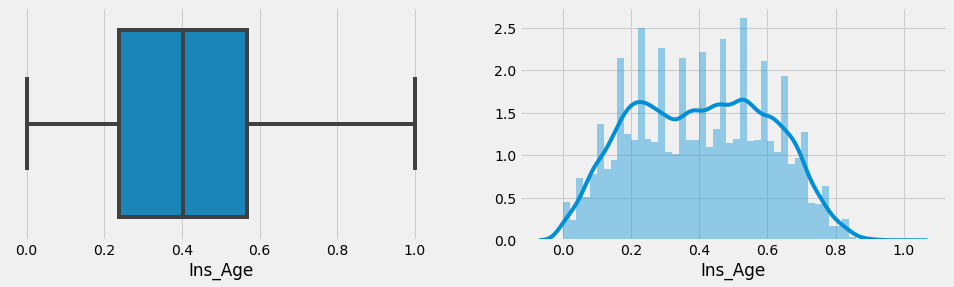

In [133]:
plt.figure(figsize=(15,4))
plt.subplot(121)
sb.boxplot(clust_df_scaled['Ins_Age'])

plt.subplot(122)
sb.distplot(clust_df_scaled['Ins_Age'])

plt.show();

- Q1 = 25 percentile, Q2 = 50 percentile, Q3 = 75 percentile, `IQR` = Q3 - Q2
- Commonly used metric for outlier detection is `IQR` 1.5 rule
- The `IOR` 1.5 rule is that data point less than lower limit i.e (Q1 - IQR\*1.5) and more than upper limit i.e ( Q3 + IQR\*1.5) are considered to be an outlier

- ***Observations:***
- **Boxplot**
- From the boxplot we can see that there no outliers in the 'Ins_Age' variable
- Within the IQR, the data points are evenly distributed above and below the median
- 50% of the data points are in IQR, wich means they are close to each other i.e. 50% of applicants have age similar to each other
- **Distplot**
- According to the plot the distribution seems a bit gaussian with spikes at regular intervals, large numbers in the middle and lesser numbers at extremes, which means more number of applicants belong to a particular age
- Even though there are spikes at certain points, it seems the data points are distributed evenly across

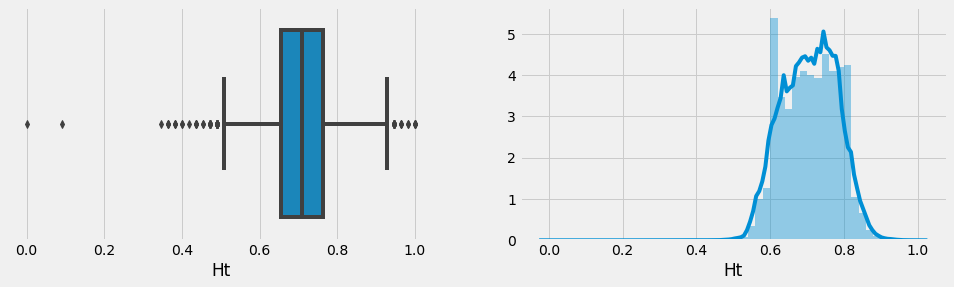

In [134]:
plt.figure(figsize=(15,4))
plt.subplot(121)
sb.boxplot(clust_df_scaled['Ht'])

plt.subplot(122)
sb.distplot(clust_df_scaled['Ht'])

plt.show();

- ***Observations:***
- **Boxplot**
- From the boxplot we can see that there outliers above upper whisker and below lower whisker in the 'Ht' variable
- There are lot of data points below lower whisker, which means there are applicants who are very young
- There are some data points above upper whisker, which means there are applicants who are very old
- However, within the IQR, the data points are evenly distributed above and below the median
- 50% of the data points are in IQR, wich means they are close to each other i.e. 50% of applicants have height similar to each other
- **Distplot**
- According to the plot the distribution seems gaussian with few spikes, large numbers are in the middle and lesser numbers at extremes, which means more number of applicants have same range for height
- The distribution is left skewed due to outliers

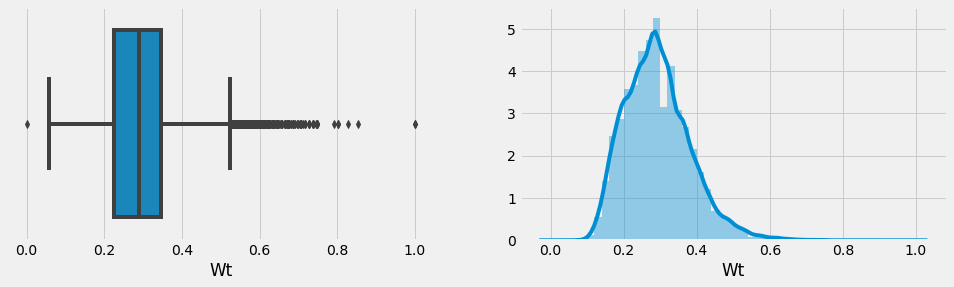

In [135]:
plt.figure(figsize=(15,4))
plt.subplot(121)
sb.boxplot(clust_df_scaled['Wt'])

plt.subplot(122)
sb.distplot(clust_df_scaled['Wt'])

plt.show();

- ***Observations:***
- **Boxplot**
- From the boxplot we can see that there lot of outliers in the 'Wt' variable
- There are few data points below lower whisker, which means there are applicants who are under-weight
- There are large number of data points above upper whisker, which means there are applicants who are over-weight and maybe even obese
- Within the IQR, the data points are evenly distributed above and below the median
- 50% of the data points are in IQR, wich means they are close to each other i.e. 50% of applicants have weight similar to each other
- **Distplot**
- According to the plot the distribution seems gaussian with few spikes, large number of data points are in the middle and lesser numbers at the extremes, which means more number of applicants have a same range for weight
- The distribution is right skewed due to outliers
- The distribution is sharp in the middle, maybe large applicants have a particular height

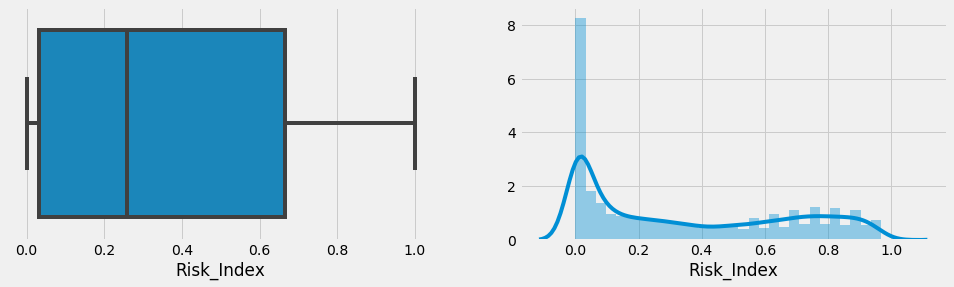

In [107]:
plt.figure(figsize=(15,4))
plt.subplot(121)
sb.boxplot(clust_df_scaled['Risk_Index'])

plt.subplot(122)
sb.distplot(clust_df_scaled['Risk_Index'])

plt.show();

- ***Observations:***
- **Boxplot**
- From the boxplot we can see that there no outliers in the 'Risk_Index' variable
- Within the IQR, there is more spread of data points above the median when compared to data points below the median
- 50% of the data points are in IQR, there is lot of spread with the IQR i.e. there is lot of deviation in the risk index of the applicants
- It seems that the reason for the larger deviation in the variable maybe because some applicants with low weight may have higher height, and some with more weight may have lesser height
- **Distplot**
- The distribution is right skewed, large number of applicants have very low risk index which is a good sign for the company
- There are few spikes at higher risk index
- Few of the applicants have high risk index
- Few of the applicants have medium risk index

### Performing Hopkins test

In [108]:
# Hopkins Statistic Code

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [164]:
%%time
# Use the Hopkins Statistic function by passing the above dataframe as a paramter by taking average of 10 scores
hopkin_list=[]
for i in range(5):
    hopkin_list.append(hopkins(clust_df_scaled))
print(np.mean(hopkin_list))

0.9611616644202131
Wall time: 13min 19s


- ***Hopkins test is performed to evaluate whether the data sets contains meaningful clusters (i.e.: non-random structures) or not. If yes, then how many clusters are there. This process is defined as the assessing of clustering tendency or the feasibility of the clustering analysis***
<br>

- ***Observations:***
- Performed hopkins test to check whether we can perform clustering on those 3 variables
- Always recommended to run hopkins test for 8-10 times as the score changes every time
- For hopkins score, performed for loop for 5 times and took average of them as data is large and system we are using is slow
- Average hopkins score of 0.99 means we can perform clustering
- For a particular dataset, if hopkins score is above 0.60 then, we can be perform clustering on that dataset

### Performing KMeans Clustering

- **Finding the optimum number of Clusters**

#### Elbow Method

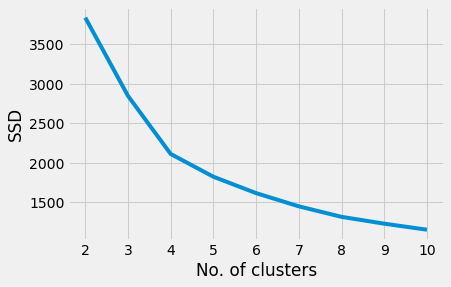

In [137]:
range_clusters = [2,3,4,5,6,7,8,9,10]
ssd = []

for cluster in range_clusters:
    kmeans = KMeans(n_clusters=cluster)
    kmeans.fit(clust_df_scaled)
    ssd.append(kmeans.inertia_)

# plot the SSDs for each number of clusters

sb.lineplot(x=range_clusters,y=ssd)
plt.xticks(ticks=np.arange(2,11))
plt.xlabel('No. of clusters')
plt.ylabel('SSD')
plt.show();

- ***Observations:***
- It looks like `4` and `8` clusters will be apropriate for clustering purpose after looking at SSD, we can see kink at `cluster=4` clearly
- However we will be using `4` clusters and check if it fits well by looking at the visualization for those clusters

#### Silhouette Score

In [138]:
%%time
range_clusters = [2,3,4,5,6,7,8,9,10]

for cluster in range_clusters:
    
    # initialize kmeans
    kmeans = KMeans(n_clusters=cluster)
    km = kmeans.fit(clust_df_scaled)
    cluster_labels = km.labels_
    
    # silhouette score
    sil_score = silhouette_score(clust_df_scaled,cluster_labels)
    print(f'For clusters={cluster}, the silhouette score is {sil_score}')

For clusters=2, the silhouette score is 0.5034160253769894
For clusters=3, the silhouette score is 0.3991351204207189
For clusters=4, the silhouette score is 0.37127876056881115
For clusters=5, the silhouette score is 0.3562347085389811
For clusters=6, the silhouette score is 0.33580951231067707
For clusters=7, the silhouette score is 0.30234085551092044
For clusters=8, the silhouette score is 0.28863707018321577
For clusters=9, the silhouette score is 0.2829534371473649
For clusters=10, the silhouette score is 0.267997544170805
Wall time: 15min 59s


- ***Observations:***
- Here according to silhouette score, `2`, `3` and `4` clusters will be apropriate for clustering purpose
- Still we will be using only `4` clusters and check if it fits well by looking at the visualization for those clusters

### K-Means with 4 clusters

In [160]:
# KMeans with 'K=4'

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(clust_df_scaled)

KMeans(n_clusters=4, random_state=42)

In [161]:
# Adding 'Cluster_labels' column to the 'clust_df_scaled' dataframe

clust_df['Cluster_labels'] = kmeans.labels_
clust_df.head()

,Id,Ins_Age,Ht,Wt,Risk_Index,Cluster_labels
0,2,0.641791,0.581818,0.148536,24.0,2
1,5,0.059701,0.600000,0.131799,28.0,0
2,6,0.029851,0.745455,0.288703,65.0,1
3,7,0.164179,0.672727,0.205021,88.0,1
4,8,0.417910,0.654545,0.234310,56.0,3


In [162]:
# Checking value counts after creating 'Cluster_labels' column

clust_df.Cluster_labels.value_counts()

2    18531
0    15059
1    13686
3    12105
Name: Cluster_labels, dtype: int64

### Model Evaluation

- **Cluster Profiling**

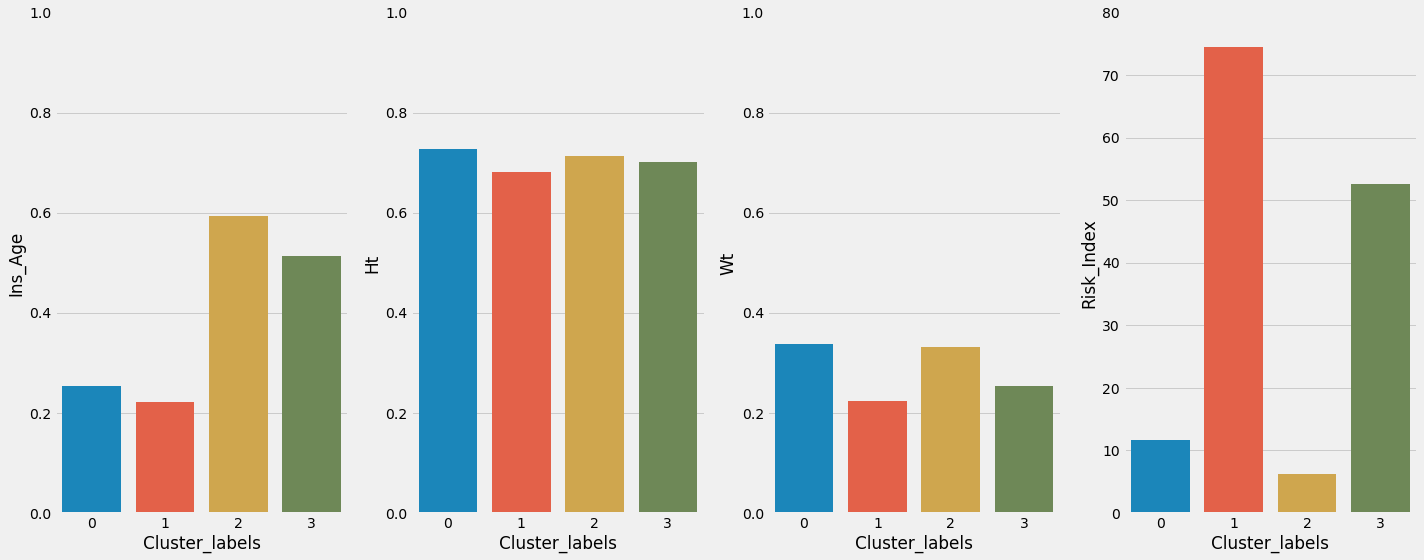

In [163]:
# Cluster Profiling by plotting barplots

plt.figure(figsize=(20,8))
plt.subplot(141)
sb.barplot(x='Cluster_labels',y='Ins_Age',data=clust_df, ci=None)
plt.ylim([0,1])

plt.subplot(142)
sb.barplot(x='Cluster_labels',y='Ht',data=clust_df, ci=None)
plt.ylim([0,1])

plt.subplot(143)
sb.barplot(x='Cluster_labels',y='Wt',data=clust_df, ci=None)
plt.ylim([0,1])

plt.subplot(144)
sb.barplot(x='Cluster_labels',y='Risk_Index',data=clust_df, ci=None)
plt.yticks(ticks=range(0,81,10))

plt.tight_layout()
plt.show();

- ***Observations:***
- **`Cluster 0`**
- This cluster has applicants who are of less age with medium height and medium weight
- The applicants in this cluster have low risk index
- Not much of a concern for applicants in this cluster
- **`Cluster 1`**
- This cluster has applicants who are of less age medium height and very low weight
- The applicants in this cluster have high risk index which is probable because their weight is not proportionate to the height, this would be the case as they may be under nourished
- Under nourishment may affect the health adversely which is a risk gor the insurance company
- The company needs take steps in order to ensure that going forward they should make the procedure a bit stricter by conducting medical tests for applicants with very less weight and less age
- **`Cluster 2`**
- This cluster has applicants who are of more age with medium height and medium weight
- The applicants in this cluster have low risk index
- Not much of a concern for applicants in this cluster
- **`Cluster 3`**
- This cluster has applicants who are of medium age medium height and very low weight
- The applicants in this cluster have high risk index which is probable because their weight is not proportionate to the height, this would be the case as they may be under nourished
- Under nourishment may affect the health adversely which is a risk gor the insurance company
- The company needs take steps in order to ensure that going forward they should make the procedure a bit stricter by conducting medical tests for applicants with very less weight and less age

# Conclusion

- From clustering analysis and bar graph visualization we can infer that the applicants in `Cluster 1` and `Cluster 3` have high risk index when compared to remaining 2 clusters
- The company has to conduct preliminary medical tests for applicants with disproportionate height and weight
- The applicants of this company have less age which is a good sign, however the company should ensure a minimum criterion and maximum criterion for age is set, and same should be done with weight